# Rakshit Sareen : rs5606@nyu.edu

In [1]:
import os
import cv2
import numpy as np
import sys
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
bwimage = "/Users/rakshitsareen/Downloads/images-project2/capitol.jpg"
bwimg = cv2.imread(bwimage,0)

### The Original Image

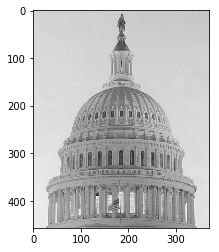

In [3]:
plt.imshow(bwimg,cmap='gray')

# Convolution

###### The code below is about convolution. It takes and image, kernel and the kernelsize as three parameters and applies convolution over the image.

In [4]:
def convolve2d(image, kernel, kernelsize):
    """
    This function assumes square kernels for now.
    """
    assert kernelsize%2 == 1 #this step is important
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image)
    image_padded = np.zeros((image.shape[0] + kernelsize - 1, image.shape[1] + kernelsize - 1))
    skipfactor = (kernelsize-1)/2
    image_padded[skipfactor:-skipfactor, skipfactor:-skipfactor] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x,y]=(kernel*image_padded[x:x+kernelsize,y:y+kernelsize]).sum()
    return output

#### Convolution with 5X5 normalised kernel

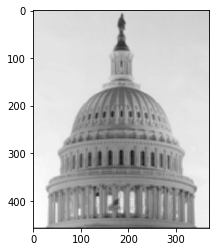

In [5]:
kernel5X5 = np.ones((5,5),np.float32)/25
output = convolve2d(bwimg,kernel5X5,5)
plt.imshow(output,cmap='gray')

### Convolution with 3X3 normalised kernel

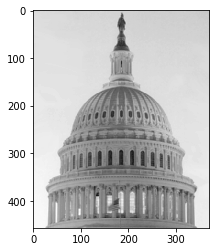

In [6]:
kernel3X3 = np.ones((3,3),np.float32)/9
output = convolve2d(bwimg,kernel3X3,3)
plt.imshow(output,cmap='gray')

### Convolution with 13 X 13 normalised kernel

In [7]:
kernel13X13 = np.ones((13,13),np.float32)/169
output = convolve2d(bwimg,kernel13X13,13)
plt.imshow(output,cmap='gray')

# Edge Detection

### This code creates derivative matrices in the x and y direction and convolves with the original image

In [8]:
yderiv = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
xderiv = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

#### We need to smooth the image using the convolution technique above 

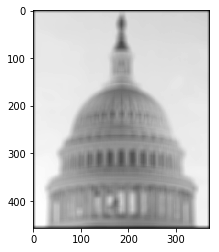

In [9]:
smoothimg = convolve2d(bwimg,kernel13X13,13)
plt.imshow(smoothimg,cmap='gray')

### Now this image is convolved with the y derivative matrix to get the y derivtive of the image

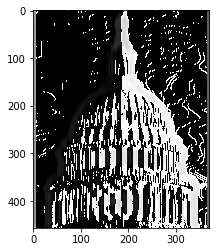

In [10]:
output = convolve2d(smoothimg,yderiv,3)
plt.imshow(output,cmap='gray')
iy = np.copy(output)

### Now this image is convolved with the x derivative matrix to get the x derivtive of the image

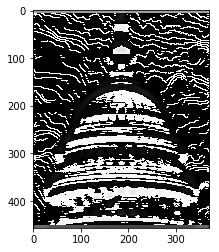

In [11]:
output = convolve2d(smoothimg,xderiv,3)
plt.imshow(output,cmap='gray')
ix = np.copy(output)

## Edge Map Calculation

#### The function below provides the calcuation of the edge map of an image. It takes the x and y derivative of the image and applies the formula sqrt(np.square(xderiv) + np.square(yderiv)) for every pixel in both the images.

In [12]:
# Calculation of Edge Map
def calculateEdgeMap(xderiv,yderiv):
    assert xderiv.shape == yderiv.shape
    output = np.zeros_like(xderiv)
    output = np.sqrt(np.square(xderiv) + np.square(yderiv))
    return output

In [13]:
edgemap = calculateEdgeMap(ix,iy)

#### This is normalizing of the values and converting the values as integer

In [14]:
edgemap = (edgemap / np.max(edgemap)) * 255
edgemap = edgemap.astype(int) # this is an important step
plt.imshow(edgemap,cmap='gray')

### Calculation of the orientation map of the image

#### The function below provides the calcuation of the edge map of an image. It takes the x and y derivative of the image and applies the formula arctan2(iy,ix) for every pixel in both the images and return the resulting image.

In [15]:
# Orientation map : Calculating the arctan 
def calculateArctan(ix,iy):
    assert ix.shape == iy.shape
    output = np.zeros_like(edgemap)
    output = np.arctan2(iy,ix)
    return output

In [16]:
orientationmap = calculateArctan(ix,iy)

#### Scaling of the orientation map and converting them into integer values

In [17]:
orientationmap = (orientationmap / np.max(orientationmap)) * 300
orientationmap = orientationmap.astype(int)

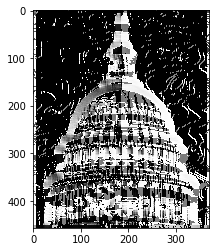

In [18]:
plt.imshow(orientationmap,cmap='gray')
plt.show()

# Template Matching

## Taking the text image and calculating the template match of the sub region of the image

The image is smoothed first with a 3X3 filter.

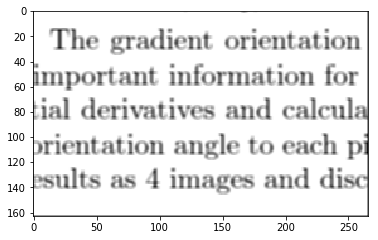

In [19]:
path = "/Users/rakshitsareen/Downloads/images-project2/text.png"
textimg = cv2.imread(path,0)
stextimg = convolve2d(textimg,kernel3X3,3)
plt.imshow(stextimg,cmap='gray')

### Picking of a template from the image. The template taken is the letter 'i' . 

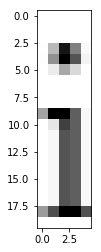

In [20]:
template = textimg[40:60, 0:5]
plt.imshow(template,cmap='gray')

#### Function to calculate the zero mean of a matrix.
##### It takes the mean of the values in the matrix and then subtracts this value from each value, so that the overall mean is 0.

In [21]:
def calculateZeroMeanTemplate(template):
    mean = np.mean(template)
    output = template - mean
    return output

In [22]:
ztemplate = calculateZeroMeanTemplate(template)

##### Plotting of the zero mean template.

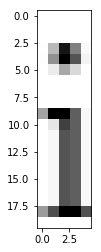

In [23]:
plt.imshow(ztemplate,cmap='gray')

### Function to convolve the template with the image. 
##### This function takes the image and template.
The recipe is to take region of the image equal to the template and convolve with the region. We need to divide the correlation with the sum of the norms of the two images. The output os returned.

In [24]:
def templateMatcher(image, template):
    (row,col) = image.shape
    (tr,tc) = template.shape
    padimg = pad_image = np.pad(image, ((tr,tr),(tc,tc)), 'constant')
    output = np.zeros(image.shape)
            
    for i in range(row):
        for j in range(col):
            
            region = padimg[i:i+tr,j:j+tc]
            region = calculateZeroMeanTemplate(region)

            assert (region.shape == template.shape), 'Dimensional mis-match'
            
            mregion = np.multiply(region, template)                        
            total_magnitude = np.linalg.norm(region) * np.linalg.norm(template)
            
            if (total_magnitude == 0):
                output[i][j] = -1
            else:
                output[i][j] = np.sum(mregion)/total_magnitude
            
    return output
    

#### The output of the correlation of the image with the template.
##### If we notice, we can see highest peaks where the image region exactly matches the template. We will apply thresholding to get the peaks and the position of where the image matched the template.

In [25]:
output = templateMatcher(textimg,ztemplate)
plt.imshow(output,cmap='gray')

#### The function to threshold the image. Reduces the value of intensities below the threshold to zero and enhances the ones above to 1 . 

In [26]:
def thresholder(matched_img, val):
    threshold_img = np.copy(matched_img)
    threshold_img[matched_img < val] = 0
    return threshold_img

### Finally the peaks which tells the location of the template in the image.

In [27]:
ans = thresholder(output,0.9)
plt.imshow(ans,cmap='gray')

In [28]:
def convolve2dGeneral(image, kernel):
    """
    This function assumes square kernels for now.
    """
    #kernel = np.flipud(np.fliplr(kernel))
    kx = kernel.shape[0]
    ky = kernel.shape[1]
    output = np.zeros_like(image)
    image_padded = np.zeros( (image.shape[0] + kx - 1, image.shape[1] + ky - 1) )
    #print image.shape , image_padded.shape
    skipfactorx = (kx - 1)/2
    skipfactory = (ky - 1)/2
    if skipfactorx == 0:
        skipfactorx += 1
    if skipfactory == 0:
        skipfactory += 1
    image_padded[skipfactorx:-skipfactorx, skipfactory:-skipfactory] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x,y]=(kernel*image_padded[x:x+kx,y:y+ky]).sum()
    return output